## Vacuum Neutrino Oscillations

Here is a notebook for homogeneous gas model.

Here we are talking about a homogeneous gas bulk of neutrinos with single energy. The EoM is
$$
i \partial_t \rho_E = \left[ \frac{\delta m^2}{2E}B ,\rho_E \right]
$$

while the EoM for antineutrinos is
$$
i \partial_t \bar\rho_E = \left[- \frac{\delta m^2}{2E}B ,\bar\rho_E \right]
$$

Initial:
Homogeneous, Isotropic, Monoenergetic $\nu_e$ and $\bar\nu_e$

The equations becomes
$$
i \partial_t \rho_E = \left[ \frac{\delta m^2}{2E} B  ,\rho_E \right]
$$
$$
i \partial_t \bar\rho_E = \left[- \frac{\delta m^2}{2E}B,\bar\rho_E \right]
$$



Define $\omega=\frac{\delta m^2}{2E}$,  $\omega = \frac{\delta m^2}{-2E}$, $\mu=\sqrt{2}G_F n_\nu$
$$
i \partial_t \rho_E = \left[ \omega B ,\rho_E \right]
$$
$$
i \partial_t \bar\rho_E = \left[\bar\omega B,\bar\rho_E \right]
$$


where

$$
B = \frac{1}{2} \begin{pmatrix} 
-\cos 2\theta_v & \sin 2\theta_v \\
\sin 2\theta_v & \cos 2\theta_v
\end{pmatrix} = 
\begin{pmatrix} 
-0.38729833462 & 0.31622776601\\
0.31622776601 & 0.38729833462
\end{pmatrix}
$$

$$
L = \begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix}
$$

Initial condition 
$$
\rho(t=0) = \begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix}
$$

$$
\bar\rho(t=0) =\begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix}
$$

define the following quantities

1. hbar$=\hbar$
%2. delm2E$= \delta m^2/2E$
%3. lamb $= \lambda$, lambb $= \bar\lambda$
%4. gF $= G_F$
%5. mu $=\mu$
6. omega $=\omega$, omegab $=-\bar\omega$

## Numerical

In [98]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline
%load_ext snakeviz

import numpy as np
from scipy.optimize import minimize
from scipy.special import expit
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

import timeit

import pandas as pd

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [99]:
# hbar=1.054571726*10**(-34)
hbar=1.0
delm2E=1.0
# lamb=1.0  ## lambda for neutrinos
# lambb=1.0 ## lambda for anti neutrinos
# gF=1.0
# nd=1.0  ## number density
# ndb=1.0   ## number density
omega=1.0
omegab=-1.0

## Here are some matrices to be used

elM = np.array([[1.0,0.0],[0.0,0.0]])
bM = 1.0/2*np.array( [ [ - 0.38729833462,0.31622776601] , [0.31622776601,0.38729833462] ] )

## sqareroot of 2
sqrt2=np.sqrt(2.0)

~~Using Mathematica, I can find the 4\*2 equations~~

In [100]:

#r11prime(t)

## The matrix eqn for neutrinos. Symplify the equation to the form A.X=0. Here I am only writing down the LHS.
## Eqn for r11'
# 1/2*( r21(t)*( bM12*delm2E - 2*sqrt2*gF*rb12(t) ) + r12(t) * ( -bM21*delm2E + 2*sqrt2*gF*rb21(t) ) - 1j*r11prime(t)  )
## Eqn for r12'
# 1/2*( r22(t)* ( bM12 ) )

### wait a minute I don't actually need to write down this. I can just do this part in numpy.

I am going to substitute all density matrix elements using their corrosponding network expressions.

So first of all, I need the network expression for the unknown functions.

A function is written as

$$ y_i= 1+t_i v_k f(t_i w_k+u_k) ,$$

while it's derivative is

$$v_k f(t w_k+u_k) + t v_k f(tw_k+u_k) (1-f(tw_k+u_k)) w_k .$$

Now I can write down the equations using these two forms.

In [101]:
def trigf(x):
    #return 1/(1+np.exp(-x)) # It's not bad to define this function here for people could use other functions other than expit(x).
    return expit(x)

In [102]:
## The time derivative part

### Here are the initial conditions

init = np.array( [[1,0],[0,0]] )


### For neutrinos

def rho(x,ti,initialCondition): # x is the input structure arrays, ti is a time point

    v11,w11,u11,v12,w12,u12,v21,w21,u21,v22,w22,u22 = np.split(x,12)[:12]
        
    elem11= np.sum(ti * v11 * trigf( ti*w11 +u11 ) )
    elem12= np.sum(ti * v12 * trigf( ti*w12 +u12 ) )
    elem21= np.sum(ti * v21 * trigf( ti*w21 +u21 ) )
    elem22= np.sum(ti * v22 * trigf( ti*w22 +u22 ) )
    
    return initialCondition + np.array([[ elem11 , elem12 ],[elem21, elem22]])


In [133]:
## Test
xtemp=np.ones(120)
rho(xtemp,0,init)

array([[ 1.,  0.],
       [ 0.,  0.]])

In [104]:
## Define Hamiltonians for both

def hamilv():
    return delm2E*bM

In [105]:
## The commutator

def commv(x,ti,initialCondition):
    
    return np.dot(hamilv(), rho(x,ti,initialCondition) ) - np.dot(rho(x,ti,initialCondition), hamilv() )


In [106]:
## Test

print bM

print hamilv()

print "neutrino\n",commv(xtemp,0,init)

[[-0.19364917  0.15811388]
 [ 0.15811388  0.19364917]]
[[-0.19364917  0.15811388]
 [ 0.15811388  0.19364917]]
neutrino
[[ 0.         -0.15811388]
 [ 0.15811388  0.        ]]


In [107]:
## The COST of the eqn set

def costvTi(x,ti,initialCondition): # l is total length of x
    
    v11,w11,u11,v12,w12,u12,v21,w21,u21,v22,w22,u22 = np.split(x,12)[:12]

    fvec11 = np.array(trigf(ti*w11 + u11) )  # This is a vector!!!
    fvec12 = np.array(trigf(ti*w12 + u12) )
    fvec21 = np.array(trigf(ti*w21 + u21) )
    fvec22 = np.array(trigf(ti*w22 + u22) )
    
    costi11= ( np.sum (v11*fvec11 + ti * v11* fvec11 * ( 1 -  fvec11  ) * w11 ) + 1.0j*  ( commv(x,ti,initialCondition)[0,0] )  )  
    costi12= ( np.sum (v12*fvec12 + ti * v12* fvec12 * ( 1 -  fvec12  ) * w12 ) + 1.0j*  ( commv(x,ti,initialCondition)[0,1] )  )  
    costi21= ( np.sum (v21*fvec21 + ti * v21* fvec21 * ( 1 -  fvec21  ) * w21 ) + 1.0j*  ( commv(x,ti,initialCondition)[1,0] )  )  
    costi22= ( np.sum (v22*fvec22 + ti * v22* fvec22 * ( 1 -  fvec22  ) * w22 ) + 1.0j*  ( commv(x,ti,initialCondition)[1,1] )  )  

    
    return (np.real(costi11))**2 + (np.real(costi12))**2+ (np.real(costi21))**2 +  (np.real(costi22))**2 + (np.imag(costi11))**2 + (np.imag(costi12))**2+ (np.imag(costi21))**2 +  (np.imag(costi22))**2



In [108]:
costvTi(xtemp,2,init)

548.68340044143918

In [109]:
## Calculate the total cost

def costv(x,t,initialCondition):

    t = np.array(t)
    
    costvTotal = np.sum( costvTList(x,t,initialCondition)  )
        
    return costvTotal
    

def costvTList(x,t,initialCondition):  ## This is the function WITHOUT the square!!! 
        
    t = np.array(t)
    
    costvList = np.asarray([])
    
    for temp in t:
        tempElement = costvTi(x,temp,initialCondition)
        costvList = np.append(costvList, tempElement)
        
    return np.array(costvList)

    

In [110]:
ttemp = np.linspace(0,10)
print ttemp

[  0.           0.20408163   0.40816327   0.6122449    0.81632653
   1.02040816   1.2244898    1.42857143   1.63265306   1.83673469
   2.04081633   2.24489796   2.44897959   2.65306122   2.85714286
   3.06122449   3.26530612   3.46938776   3.67346939   3.87755102
   4.08163265   4.28571429   4.48979592   4.69387755   4.89795918
   5.10204082   5.30612245   5.51020408   5.71428571   5.91836735
   6.12244898   6.32653061   6.53061224   6.73469388   6.93877551
   7.14285714   7.34693878   7.55102041   7.75510204   7.95918367
   8.16326531   8.36734694   8.57142857   8.7755102    8.97959184
   9.18367347   9.3877551    9.59183673   9.79591837  10.        ]


In [111]:
ttemp = np.linspace(0,10)
print costvTList(xtemp,ttemp,init)
print costv(xtemp,ttemp,init)

[  213.82865816   260.6902141    305.39804042   346.64561769   383.92404363
   417.38363551   447.62744495   475.50456712   501.94255695   527.83232625
   553.96205346   580.9889115    609.43601124   639.70382149   672.08826342
   706.80047667   743.98543605   783.73809092   826.11662116   871.15291059
   918.86057784   969.24098374  1022.28762711  1077.98929363  1136.33226168
  1197.30180822  1260.88320401  1327.06234224  1395.82610838  1467.16257123
  1541.06105291  1617.51211991  1696.50752459  1778.04011815  1862.10374927
  1948.69315796  2037.80387086  2129.43210193  2223.57466068  2320.22886896
  2419.39248675  2521.06364669  2625.2407969   2731.92265145  2841.10814774
  2952.79641004  3066.98671853  3183.67848298  3302.87122064  3424.56453766]
70866.278804


## Minimization

Here is the minimization

In [136]:
tlin = np.linspace(0,15,80)
# tlinTest = np.linspace(0,14,10) + 0.5
# initGuess = np.ones(120)
initGuess = np.random.rand(1,60)[0]

costvF = lambda x: costv(x,tlin,init)
costvFTest = lambda x: costv(x,tlinTest,init)

In [137]:
print costv(initGuess,tlin,init), costv(initGuess,tlinTest,init)

15699.9832803 1980.60092864


In [138]:
## %%snakeviz
# startCG = timeit.default_timer()
#costFResultCG = minimize(costF,initGuess,method="CG")
#stopCG = timeit.default_timer()

#print stopCG - startCG

#print costFResultCG

In [139]:
#%%snakeviz
#startBFGS = timeit.default_timer()
#costvFResultBFGS = minimize(costvF,initGuess,method="BFGS")
#stopBFGS = timeit.default_timer()

#print stopBFGS - startBFGS

#print costvFResultBFGS

In [140]:
%%snakeviz
startSLSQP = timeit.default_timer()
costvFResultSLSQP = minimize(costvF,initGuess,method="SLSQP")
stopSLSQP = timeit.default_timer()

print stopSLSQP - startSLSQP

print costvFResultSLSQP

1861.06750393
  status: 9
 success: False
    njev: 101
    nfev: 6307
     fun: 0.56142756048705256
       x: array([  2.17643398e-01,   2.57272605e-01,   2.84423339e-01,
        -1.37612817e-02,  -4.70645891e-01,   2.04957509e-01,
         1.33413107e+00,  -2.49177774e+00,   2.36605722e+00,
         1.67344198e+00,   9.08796580e-01,   5.83577938e-01,
        -1.87428458e+00,   1.46129888e+00,   1.75055737e+00,
         3.73042837e-01,  -1.32336888e-02,   9.69759818e-01,
        -4.75118119e-01,  -1.34655357e-01,  -3.48334621e+00,
         1.76458667e+00,  -2.56772338e+00,  -2.32398116e-01,
        -2.70783423e+00,  -1.04640530e+00,   1.25783795e+00,
        -3.79929864e+00,  -1.45095502e+00,   2.42986333e-01,
        -1.63478525e+00,   9.40383264e-04,   8.71300323e-02,
         6.55772629e-01,   8.77648469e-01,   3.56381202e+00,
         4.07241047e-01,   2.59411817e+00,   3.79939491e+00,
         2.30693651e-01,   1.05957579e+00,  -2.47588499e-01,
         4.65519461e-01,  -9.894141

In [141]:
#%%snakeviz
#startSLSQPTest = timeit.default_timer()
#costvFResultSLSQPTest = minimize(costvFTest,initGuess,method="SLSQP")
#stopSLSQPTest = timeit.default_timer()

#print stopSLSQPTest - startSLSQPTest

#print costvFResultSLSQPTest

In [142]:
costvFResultSLSQP.get('x')

array([  2.17643398e-01,   2.57272605e-01,   2.84423339e-01,
        -1.37612817e-02,  -4.70645891e-01,   2.04957509e-01,
         1.33413107e+00,  -2.49177774e+00,   2.36605722e+00,
         1.67344198e+00,   9.08796580e-01,   5.83577938e-01,
        -1.87428458e+00,   1.46129888e+00,   1.75055737e+00,
         3.73042837e-01,  -1.32336888e-02,   9.69759818e-01,
        -4.75118119e-01,  -1.34655357e-01,  -3.48334621e+00,
         1.76458667e+00,  -2.56772338e+00,  -2.32398116e-01,
        -2.70783423e+00,  -1.04640530e+00,   1.25783795e+00,
        -3.79929864e+00,  -1.45095502e+00,   2.42986333e-01,
        -1.63478525e+00,   9.40383264e-04,   8.71300323e-02,
         6.55772629e-01,   8.77648469e-01,   3.56381202e+00,
         4.07241047e-01,   2.59411817e+00,   3.79939491e+00,
         2.30693651e-01,   1.05957579e+00,  -2.47588499e-01,
         4.65519461e-01,  -9.89414135e-03,   2.12198828e+00,
        -1.41153423e-01,  -1.20860548e-01,  -2.36706830e-01,
         3.69954091e-01,

In [143]:
#np.savetxt('./assets/homogen/optimize_ResultSLSQPT2120_Vac.txt', costvFResultSLSQP.get('x'), delimiter = ',')

## Functions

Find the solutions to each elements.

In [144]:
# costvFResultSLSQPx = np.genfromtxt('./assets/homogen/optimize_ResultSLSQP.txt', delimiter = ',')

In [145]:
## The first element of neutrino density matrix
xresult = np.asarray(costvFResultSLSQP.get('x'))
#xresult = np.asarray(costvFResultBFGS.get('x'))

print xresult

plttlin=np.linspace(0,15,100)

pltdata11 = np.array([])
pltdata11Test = np.array([])
pltdata22 = np.array([])

for i in plttlin:
    pltdata11 = np.append(pltdata11 ,rho(xresult,i,init)[0,0] )
    
print pltdata11

#for i in plttlin:
#    pltdata11Test = np.append(pltdata11Test ,rho(xresultTest,i,init)[0,0] )
#    
#print pltdata11Test


for i in plttlin:
    pltdata22 = np.append(pltdata22 ,rho(xresult,i,init)[1,1] )
    
print pltdata22

print rho(xresult,0,init)

[  2.17643398e-01   2.57272605e-01   2.84423339e-01  -1.37612817e-02
  -4.70645891e-01   2.04957509e-01   1.33413107e+00  -2.49177774e+00
   2.36605722e+00   1.67344198e+00   9.08796580e-01   5.83577938e-01
  -1.87428458e+00   1.46129888e+00   1.75055737e+00   3.73042837e-01
  -1.32336888e-02   9.69759818e-01  -4.75118119e-01  -1.34655357e-01
  -3.48334621e+00   1.76458667e+00  -2.56772338e+00  -2.32398116e-01
  -2.70783423e+00  -1.04640530e+00   1.25783795e+00  -3.79929864e+00
  -1.45095502e+00   2.42986333e-01  -1.63478525e+00   9.40383264e-04
   8.71300323e-02   6.55772629e-01   8.77648469e-01   3.56381202e+00
   4.07241047e-01   2.59411817e+00   3.79939491e+00   2.30693651e-01
   1.05957579e+00  -2.47588499e-01   4.65519461e-01  -9.89414135e-03
   2.12198828e+00  -1.41153423e-01  -1.20860548e-01  -2.36706830e-01
   3.69954091e-01  -3.83695436e-02   3.60184169e-01  -2.23499048e+00
   1.85745307e-02   1.33534647e+00   1.85724646e+00   3.38670337e-01
  -1.85114177e+00   8.18516796e-01

In [146]:
rho(xresult,6.6,init)

array([[ 0.80168077, -0.23822989],
       [-0.23575452,  0.19083108]])

In [147]:
#np.savetxt('./assets/homogen/optimize_pltdatar11.txt', pltdata11, delimiter = ',')
#np.savetxt('./assets/homogen/optimize_pltdatar22.txt', pltdata22, delimiter = ',')

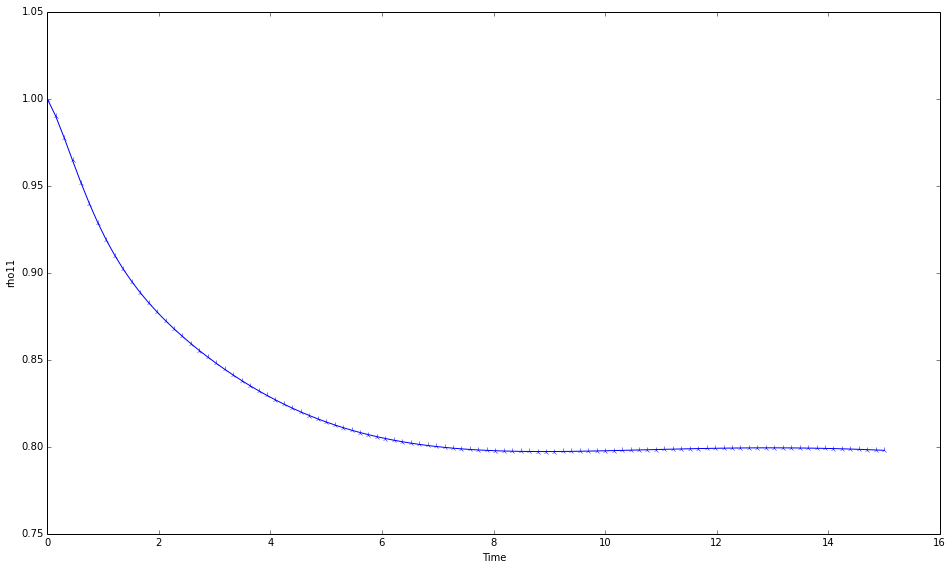

In [148]:
plt.figure(figsize=(16,9.36))
plt.ylabel('rho11')
plt.xlabel('Time')
plt11=plt.plot(plttlin,pltdata11,"b4-",label="vac_rho11")
#plt.plot(plttlin,pltdata11Test,"m4-",label="vac_rho11Test")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="vac_HG-rho11")


# tls.embed("https://plot.ly/~emptymalei/73/")

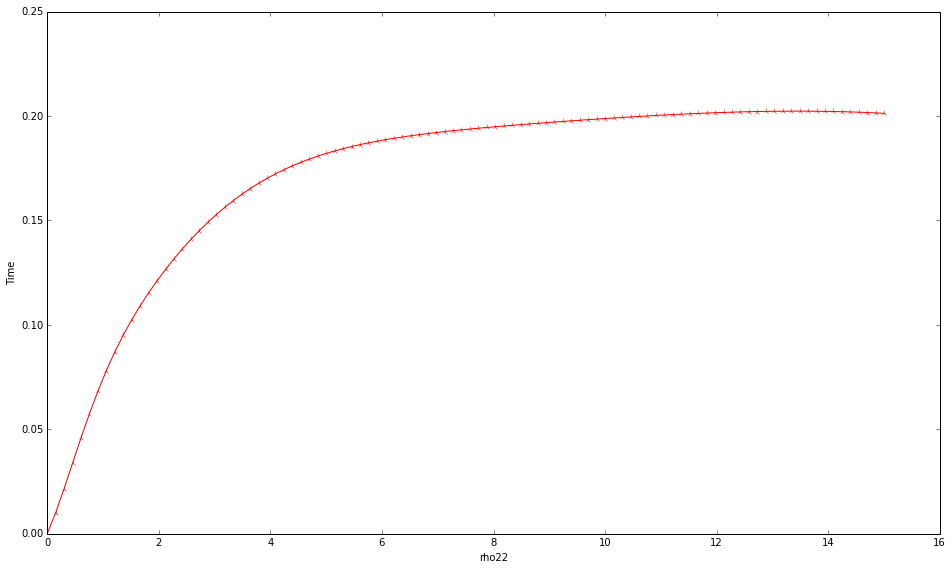

In [149]:
plt.figure(figsize=(16,9.36))
plt.ylabel('Time')
plt.xlabel('rho22')
plt22=plt.plot(plttlin,pltdata22,"r4-",label="vac_rho22")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="vac_HG-rho22")

In [150]:
MMA_optmize_Vac_pltdata.size

4501

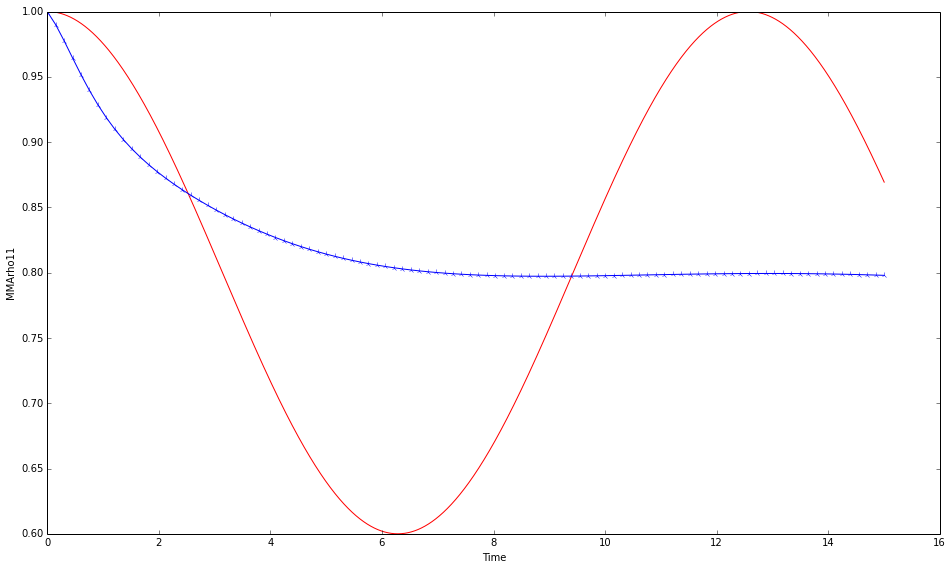

In [151]:
MMA_optmize_Vac_pltdata = np.genfromtxt('./assets/homogen/MMA_optmize_Vac_pltdata.txt', delimiter = ',')

plt.figure(figsize=(16,9.36))
plt.ylabel('MMArho11')
plt.xlabel('Time')
plt.plot(np.linspace(0,15,4501),MMA_optmize_Vac_pltdata,"r-",label="MMAVacrho11")
plt.plot(plttlin,pltdata11,"b4-",label="vac_rho11")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="MMA-rho11-Vac-80-60")

## Practice

In [ ]:
xtemp1 = np.arange(4)
xtemp1.shape = (2,2)
print xtemp1
xtemp1[0,1]
np.dot(xtemp1,xtemp1)
xtemp1[0,1]